In [ ]:
!pip install --upgrade pip
!pip install numpy==1.26.4
!pip install scipy==1.10.1
!pip install gensim==4.3.2
!pip install nltk matplotlib seaborn scikit-learn statsmodels


ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python >=3.8,<3.12; 1.10.0rc1 Requires-Python >=3.8,<3.12; 1.10.0rc2 Requires-Python >=3.8,<3.12; 1.10.1 Requires-Python >=3.8,<3.12; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0rc3 Requires-Python >=3.8,<3.12; 1.9.1 Requires-Python >=3.8,<3.12
ERROR: Could not find a version that satisfies the requirement scipy==1.10.1 (from versions:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


In [13]:
# Load dataset
df = pd.read_csv("/content/preprocessed_content.csv")

# Keep only required columns
df = df[['ticker', 'year', 'preprocessed_content']]

# Rename columns to academic-friendly names
df.rename(columns={
    'ticker': 'company_name',
    'year': 'report_year',
    'preprocessed_content': 'report_text'
}, inplace=True)

# Drop missing text
df.dropna(subset=['report_text'], inplace=True)

df.head()


,company_name,report_year,report_text
0,BSX,2020,style guide colour colour use imagecolour prof...
1,BSX,2022,sustainability report look mining green office...
2,EXR,2022,report environment social governance esg basel...
3,ADM,2019,corporate social responsibilty report introduc...
4,ADM,2020,sustainability admiral commit maintain respons...


FILTER ENERGY SECTOR COMPANIES

In [14]:
energy_tickers = [
    'XOM', 'CVX', 'COP', 'SLB', 'EOG',
    'PSX', 'VLO', 'MPC', 'OXY', 'HAL'
]

df = df[df['company_name'].isin(energy_tickers)]

df['company_name'].value_counts()


,count
company_name,
COP,4
CVX,4
MPC,4
SLB,4
XOM,4
EOG,3
PSX,3
VLO,2
OXY,1


FILTER YEARS (2020–2024)

In [15]:
df = df[(df['report_year'] >= 2020) & (df['report_year'] <= 2024)]

df['report_year'].value_counts().sort_index()


,count
report_year,
2020,7
2021,8
2022,5


TEXT VECTORIZATION (LDA INPUT)

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_df=0.85,
    min_df=5,
    stop_words='english'
)

dtm = vectorizer.fit_transform(df['report_text'])

print("Document-Term Matrix shape:", dtm.shape)


Document-Term Matrix shape: (20, 2213)


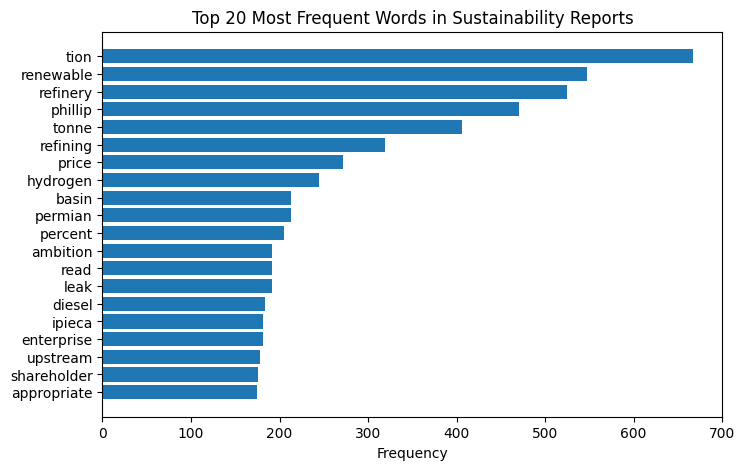

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

word_counts = np.array(dtm.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

freq_df = pd.DataFrame({
    'word': words,
    'frequency': word_counts
}).sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(8,5))
plt.barh(freq_df['word'], freq_df['frequency'])
plt.gca().invert_yaxis()
plt.title("Top 20 Most Frequent Words in Sustainability Reports")
plt.xlabel("Frequency")
plt.show()


TOPIC MODELLING (LDA)

In [44]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=6,
    random_state=42
)

lda.fit(dtm)


LatentDirichletAllocation(n_components=6, random_state=42)

DISPLAY TOPIC KEYWORDS

In [45]:
def display_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx+1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out())



Topic 1:
percent, pneumatic, leak, basin, sheet, introduction, exploration, drilling, price, proprietary

Topic 2:
plastic, percent, shareholder, ipieca, affiliate, lobbying, socioeconomic, minority, api, corporation

Topic 3:
refinery, phillip, renewable, refining, tonne, diesel, midstream, count, hazardous, freshwater

Topic 4:
image, lean, man, array, visualization, multiyear, title, poverty, zone, hvac

Topic 5:
tonne, upstream, renewable, digital, hse, hydrogen, ipieca, enterprise, empower, ccus

Topic 6:
tion, price, read, permian, car, basin, tax, oppor, ambition, acre


In [46]:
lda_output = lda.transform(dtm)


In [47]:
df['dominant_topic'] = lda_output.argmax(axis=1) + 1


In [36]:
topic_values = lda.transform(dtm)

topic_df = pd.DataFrame(
    topic_values,
    columns=[f"Topic_{i+1}" for i in range(topic_values.shape[1])]
)

df = pd.concat([df.reset_index(drop=True), topic_df], axis=1)

df.head()


,company_name,report_year,report_text,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,sentiment_score,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,COP,2020,chairman ceo message board message spotlight c...,0.000045,0.000045,0.000045,0.000044,0.000045,0.999778,1.0,0.000045,0.000045,0.000045,0.000044,0.000045,0.999778
1,COP,2021,content chairman ceo message board message int...,0.000024,0.000024,0.000024,0.000024,0.054394,0.945509,1.0,0.000024,0.000024,0.000024,0.000024,0.054394,0.945509
2,COP,2022,report social create share value work communit...,0.000024,0.000024,0.000024,0.000024,0.098145,0.901760,1.0,0.000024,0.000024,0.000024,0.000024,0.098145,0.901760
3,CVX,2020,complete reporting visit corporate sustainabil...,0.000067,0.127754,0.150130,0.000066,0.651085,0.070897,1.0,0.000067,0.127754,0.150130,0.000066,0.651085,0.070897
4,CVX,2021,corporate sustainability report permian basin ...,0.000049,0.071702,0.246684,0.000048,0.591797,0.089721,1.0,0.000049,0.071702,0.246684,0.000048,0.591797,0.089721


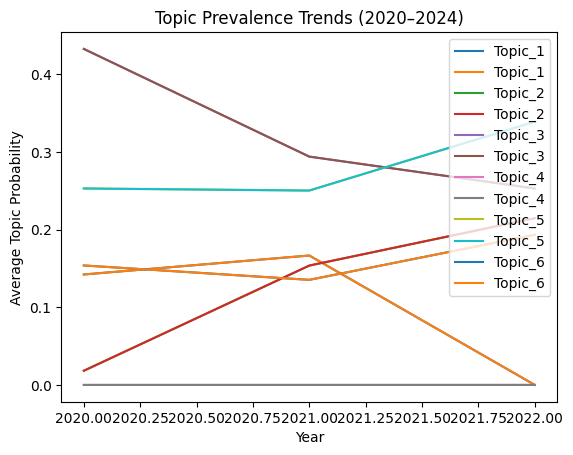

In [48]:
topic_year = df.groupby('report_year')[topic_df.columns].mean()

topic_year.plot()
plt.title("Topic Prevalence Trends (2020–2024)")
plt.xlabel("Year")
plt.ylabel("Average Topic Probability")
plt.show()


SENTIMENT ANALYSIS (VADER)

In [38]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['report_text'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

df[['sentiment_score']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,sentiment_score
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


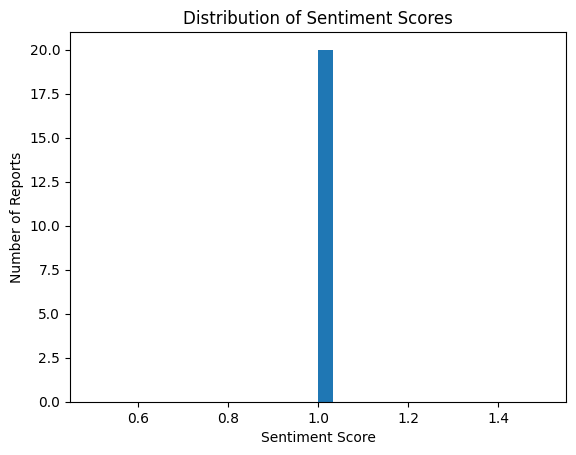

In [49]:
plt.figure()
plt.hist(df['sentiment_score'], bins=30)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Reports")
plt.show()


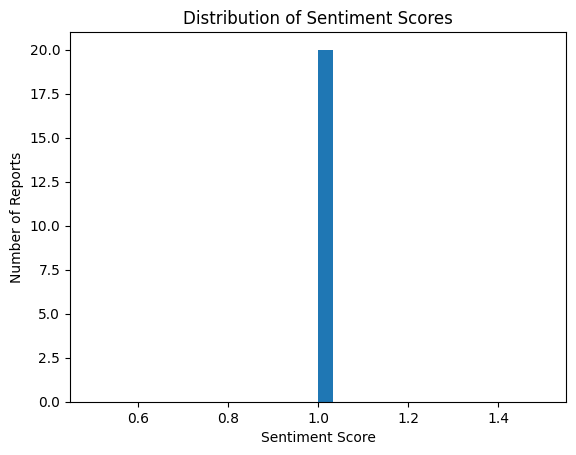

In [50]:
plt.figure()
plt.hist(df['sentiment_score'], bins=30)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Reports")
plt.show()


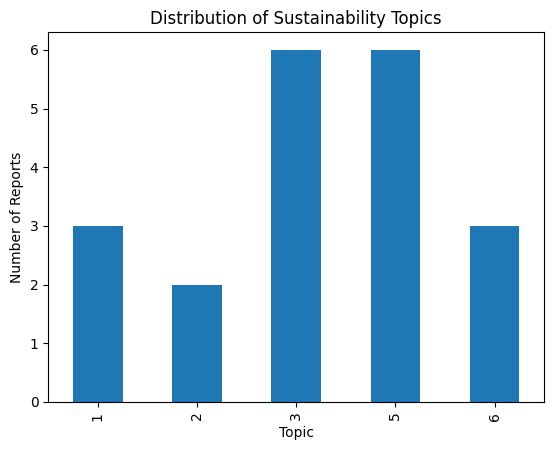

In [51]:
df['dominant_topic'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Sustainability Topics")
plt.xlabel("Topic")
plt.ylabel("Number of Reports")
plt.show()


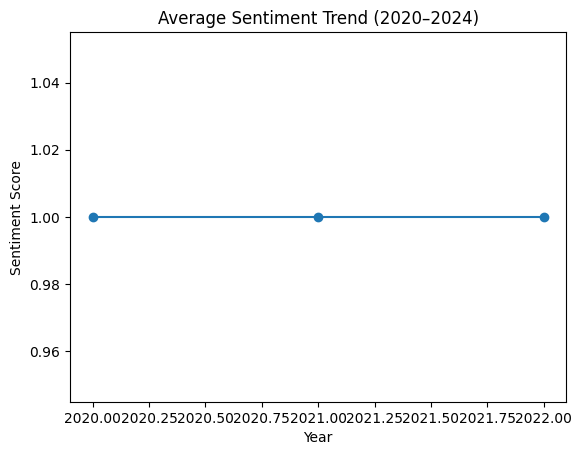

In [53]:
df.groupby('report_year')['sentiment_score'].mean().plot(marker='o')
plt.title("Average Sentiment Trend (2020–2024)")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.show()


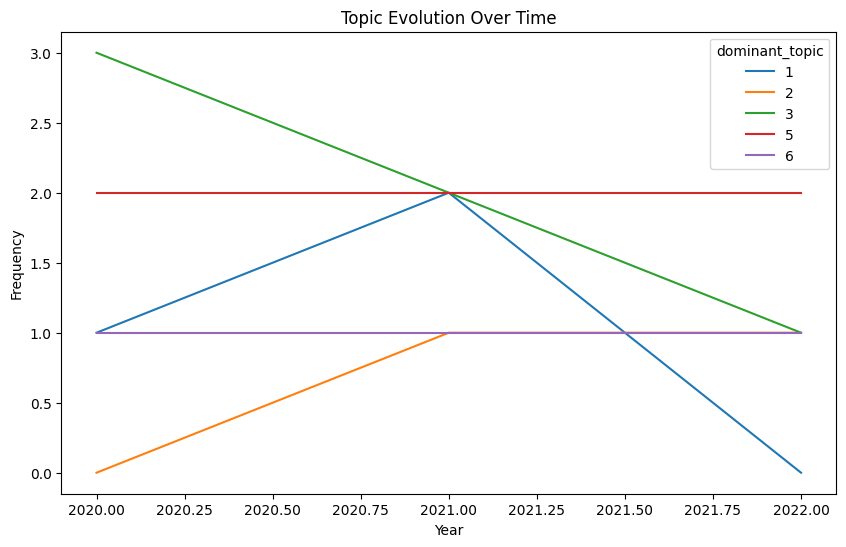

In [55]:
topic_year = df.groupby(['report_year', 'dominant_topic']).size().unstack(fill_value=0)

topic_year.plot(figsize=(10,6))
plt.title("Topic Evolution Over Time")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()


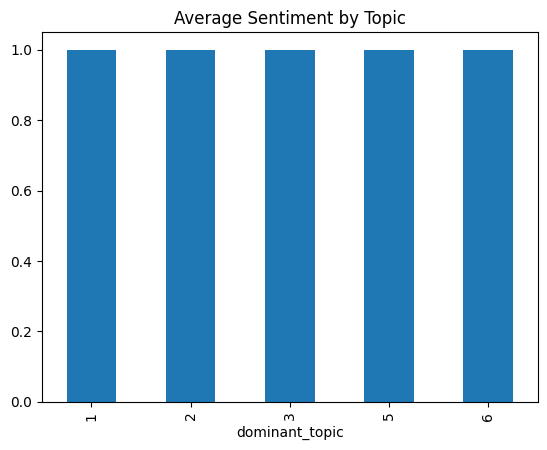

In [56]:
df.groupby('dominant_topic')['sentiment_score'].mean().plot(kind='bar')
plt.title("Average Sentiment by Topic")
plt.show()


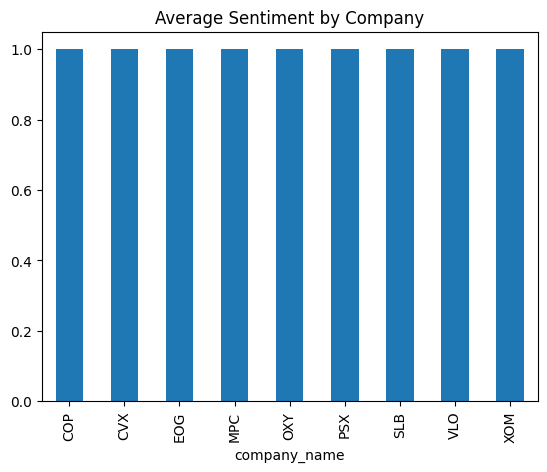

In [57]:
df.groupby('company_name')['sentiment_score'].mean().plot(kind='bar')
plt.title("Average Sentiment by Company")
plt.show()


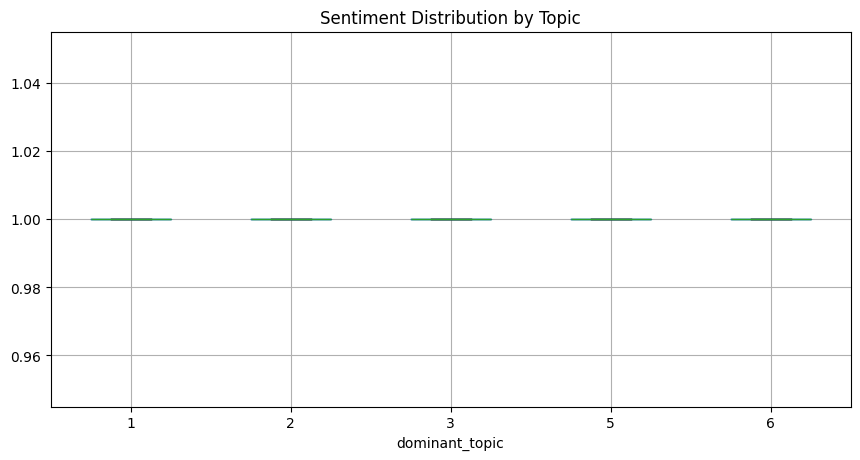

In [58]:
df.boxplot(column='sentiment_score', by='dominant_topic', figsize=(10,5))
plt.title("Sentiment Distribution by Topic")
plt.suptitle("")
plt.show()


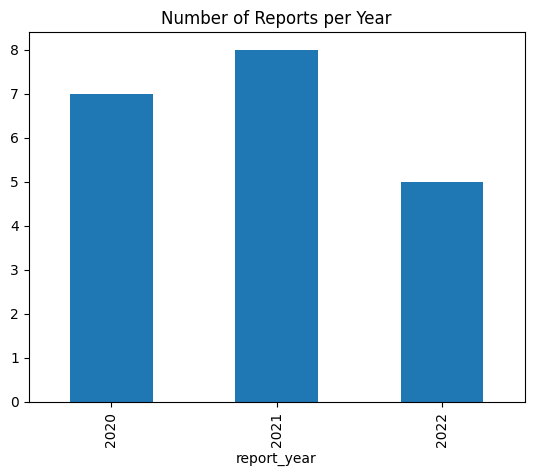

In [59]:
df['report_year'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Reports per Year")
plt.show()
